In [146]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier

In [147]:
def getNumber(data, digit):
    # wähle alle Zeilen in denen die erste Spalte (Spalte mit den Ziffer) mit 'digit' übereinstimmt
    data_number = pd.DataFrame(data[data[0] == digit]) 
    # schneide die erste Spalte weg und gebe den rest zurück
    separated_data = data_number.iloc[:,1:]
    return separated_data

def getNumberImage(data, digit, aggregation):
    # ruft die Hilfsfunktion getNumber auf um alle Bilddaten Daten zu einer Ziffer zu holen
    image_data = getNumber(data, digit)
    # bilde aus allen Bildern zu der einen Ziffer ein aggrigiertes Bild
    if(aggregation == 'median'):
        df1 = pd.DataFrame(image_data.median())
    else:
        df1 = pd.DataFrame(image_data.mean())        
    
    # wandle das format von (1,256) -> (16,16) und gebe diesen transformierten DataFrame zurück
    return df1.values.reshape(16,16)

In [149]:
class Experiment:
    def __init__(self, targets_train, targets_predict):
        self.results_train = pd.DataFrame(targets_train, columns=["targets"])
        self.results_predict = pd.DataFrame(targets_predict, columns = ["targets"])
        self.input_data = {}
        
        self.names = []        
        self.configs = []

        
    def get_names(self):
        return self.names
    
    
    def get_results(self):
        return self.results_train, self.results_predict
    
    def get_config_map(self):
        for conf in self.configs:
            print("CONFIG:", conf['name'], conf['input_data_name'], "\tNum features:", self.input_data[conf['input_data_name']]['data'].shape[1])
    
    
    def add_input_data(self, name, data, description=""):
        self.input_data[name] = {'description': description, 'data': data}
    
    
    def add_config(self, algo, name, input_data_name):
        # TODO: add check for dublicate names
        if input_data_name not in self.input_data:
            print("ERROR: feature_set_name not found")
            return 
        
        self.names.append(name)
        self.configs.append({ 'name': name, 'algo': algo, 'input_data_name': input_data_name, 'fit': -1})
        

    def _fit(self, conf):
        # get features
        input_data = self.input_data[conf['input_data_name']]['data']

        # fit the features
        print("Fitting ", conf['name'], "... ",)
        
        start = time.time() # startzeit
        conf['fit'] = conf['algo'].fit(input_data, self.results_train['targets'])
        end = time.time() # startzeit
        
        print("done in ", end - start , "s.")

        
    def _predict(self, conf, data, train):
        if data.shape[1] != self.input_data[conf['input_data_name']]['data'].shape[1]:
            print("ERROR: Number of input features does not match (", conf['name'], ")")
            return
        
        print("Predicting data with", conf['name'], "... ",)
        
        start = time.time() # startzeit
        if train:
            self.results_train[conf['name']] = conf['algo'].predict(data)
        else:
            self.results_predict[conf['name']] = conf['algo'].predict(data)
                                                                    
        end = time.time() # startzeit
        
        print("done in ", end - start , "s.")

        
    def fit(self):
        '''Only trains algorithms if no fit has been calculated before'''
        for conf in self.configs:
            if conf['fit'] == -1:
                self._fit(conf)

                
    def fit_all(self, data):
        '''Trains all algorithms with given data'''
        for conf in self.configs:
            self._fit(conf)

            
    def refit(self, data):
        '''Retrains all algorithms with given data that have been trained before'''
        for conf in self.configs:
            if conf['fit'] != -1:
                self._fit(conf)

                
    def predict(self, name, data, train = False):
        for conf in self.configs:
            if conf['fit'] != -1 and conf['name'] == name:
                self._predict(conf, data, train)

    def predict_all(self, data, train = False):
        for conf in self.configs:
            if conf['fit'] != -1:
                self._predict(conf, data, train)

                
    def get_count_df(self, name):
        count_matrix = np.zeros((10,10)) 
        for digit in range(0,10):
            cluster_counts = self.results_train[self.results_train['targets'] == digit].groupby(name).count()['targets']
            for cluster in cluster_counts.keys():
                count_matrix[digit][cluster] = cluster_counts[cluster]
        
        col_names = []
        for i in range(0,10):
            col_names.append("C_" + str(i))
    
        return pd.DataFrame(count_matrix, columns=col_names)

    def get_norm_df(self, name):
        count_df = self.get_count_df(name)
        return count_df.divide(count_df.sum(1), axis=0)
    
    
    def get_all_error_rates(self):
        error_rates = {}
        for conf in self.configs:
            if (conf['fit'] != -1) & (conf['name'] in self.results_train.columns):
                error_rates[conf['name']] = self.get_error_rate(conf['name'])
        return error_rates
                
    def get_error_rate(self, name):
        '''Determine classification error by identifying best fitting column assignment'''

In [150]:
# mit header=None, wird die erste Zeile der Datei nicht als Header interpretiert 
#              (Man könnte den Header in einem solchen Fall als Zeile mit den Spaltenüberschriften bezeichnen)
# mit sep=" ", geben wir an, dass wir das Leerzeichen als Seperator verwenden wollen. 
#              D.h. zwei durch ein Leerzeichen separierte Werte sollen als zwei Werte eingelesen werden.
data_train = pd.read_csv("Daten/zip.train", header=None, sep=" ") 

In [151]:
cleaned_train_data = data.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_train_data.shape

(7291, 257)

In [152]:
cleaned_train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,3.903443,-0.996417,-0.981138,-0.951153,-0.887738,-0.773468,-0.610302,-0.368991,-0.045769,-0.052641,...,-0.198547,0.139823,0.116439,-0.314108,-0.653711,-0.837858,-0.922194,-0.957393,-0.979290,-0.994678
std,2.996386,0.051713,0.151202,0.244264,0.360516,0.502659,0.628710,0.716032,0.768304,0.752979,...,0.772895,0.752984,0.757336,0.725859,0.582555,0.414646,0.300830,0.228700,0.158998,0.066056
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999000,-0.950000,...,-1.000000,-0.661500,-0.738000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.719000,0.061000,0.002000,...,-0.353000,0.368000,0.336000,-0.579000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,7.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.962000,-0.391000,0.254500,0.696000,0.674500,...,0.554000,0.835000,0.815000,0.346000,-0.504500,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,9.000000,0.638000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592000


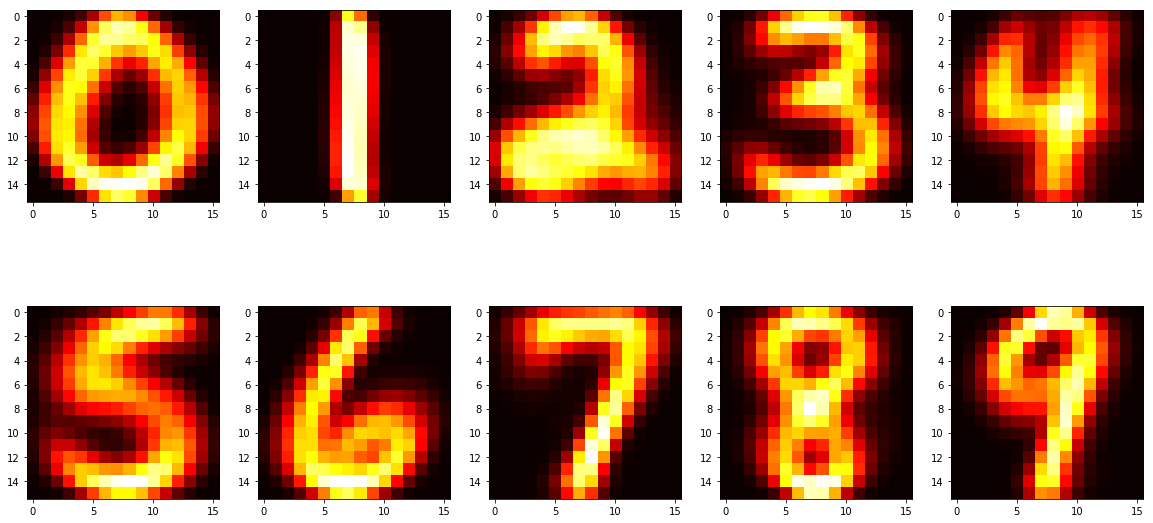

In [153]:
plt.figure(1, figsize=(20, 10))
for i in range(0,10):
    image = getNumberImage(cleaned_train_data,i,'mean')

    # Call signature: subplot(nrows, ncols, index, **kwargs)
    plt.subplot(2,5, 1 + i)
    plt.imshow(image, cmap='hot', interpolation='none')

plt.show()

## Classification mit KNN

In [154]:
input_train_data = cleaned_train_data.iloc[:,1:].values
input_train_data.shape


(7291, 256)

In [156]:
# Set targets
exp_train = Experiment(cleaned_train_data[0].values,cleaned_train_data[0].values)

In [157]:
# input featurs are the individual pixels of the image - without transformation
exp_train.add_input_data('256_pixel', input_train_data)

In [158]:
exp_train.add_config(KNeighborsClassifier(n_neighbors=1), 'KNN_1', '256_pixel')

In [159]:
exp_train.get_names()

['KNN_1']

In [160]:
exp_train.get_config_map()

CONFIG: KNN_1 256_pixel 	Num features: 256


In [161]:
exp_train.fit()

Fitting  KNN_1 ... 
done in  0.6720383167266846 s.


# 'Train' KNN with zip.train & calculate training error

In [165]:
exp_train.predict_all(input_train_data,train = True)

Predicting data with KNN_1 ... 
done in  15.088863134384155 s.


In [168]:
results_train = exp_train.get_results()
results_train.head()

(      targets  KNN_1
 0         6.0    6.0
 1         5.0    5.0
 2         4.0    4.0
 3         7.0    7.0
 4         3.0    3.0
 5         6.0    6.0
 6         3.0    3.0
 7         1.0    1.0
 8         0.0    0.0
 9         1.0    1.0
 10        7.0    7.0
 11        0.0    0.0
 12        1.0    1.0
 13        1.0    1.0
 14        7.0    7.0
 15        7.0    7.0
 16        4.0    4.0
 17        8.0    8.0
 18        0.0    0.0
 19        1.0    1.0
 20        4.0    4.0
 21        8.0    8.0
 22        7.0    7.0
 23        4.0    4.0
 24        8.0    8.0
 25        7.0    7.0
 26        3.0    3.0
 27        7.0    7.0
 28        4.0    4.0
 29        1.0    1.0
 ...       ...    ...
 7261      5.0    5.0
 7262      0.0    0.0
 7263      3.0    3.0
 7264      3.0    3.0
 7265      6.0    6.0
 7266      5.0    5.0
 7267      0.0    0.0
 7268      3.0    3.0
 7269      5.0    5.0
 7270      0.0    0.0
 7271      5.0    5.0
 7272      0.0    0.0
 7273      3.0    3.0
 7274     

In [167]:
1.0*(results_train['targets'] == results_train['KNN_3']).sum()/results_train['targets'].count()

TypeError: tuple indices must be integers or slices, not str

In [66]:
1.0*(results_train['targets'] == results_train['KNN_1']).sum()/results_train['targets'].count()

1.0

In [54]:
1.0*(results_train['targets'] == results_train['KNN_20']).sum()/results_train['targets'].count()

0.952955698806748

# Validate with zip.test


In [71]:
test_data = pd.read_csv("Daten/zip.test", header=None, sep=" ") 
cleaned_test_data = test_data.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_test_data.shape
input_test_data = cleaned_test_data.iloc[:,1:].values
input_test_data.shape

(2007, 256)

In [ ]:
exp_test = Experiment(cleaned_train_data[0].values)
# input featurs are the individual pixels of the image - without transformation
exp_test.add_input_data('256_pixel', input_train_data)
exp_test.add_config(KNeighborsClassifier(n_neighbors=1), 'KNN_1', '256_pixel')

In [91]:
for k in np.arange(1,85,2):
    dataname = 'KNN_'+str(k)
    #print(dataname)
    #exp_test.add_config(KNeighborsClassifier(n_neighbors=k), dataname, '256_pixel')

KNN_1
KNN_3
KNN_5
KNN_7
KNN_9
KNN_11
KNN_13
KNN_15
KNN_17
KNN_19
KNN_21
KNN_23
KNN_25
KNN_27
KNN_29
KNN_31
KNN_33
KNN_35
KNN_37
KNN_39
KNN_41
KNN_43
KNN_45
KNN_47
KNN_49
KNN_51
KNN_53
KNN_55
KNN_57
KNN_59
KNN_61
KNN_63
KNN_65
KNN_67
KNN_69
KNN_71
KNN_73
KNN_75
KNN_77
KNN_79
KNN_81
KNN_83


In [77]:
exp_test.get_names()
exp_test.get_config_map()
exp_test.fit()
exp_test.predict_all(input_test_data)
results_test = exp_test.get_results()
results_test.head()

CONFIG: KNN_1 256_pixel 	Num features: 256
Fitting  KNN_1 ... 
done in  0.5380308628082275 s.
Predicting data with KNN_1 ... 


ValueError: Length of values does not match length of index

In [76]:
cleaned_test_data.shape[1]

257

# Calculate test error

In [ ]:
err_rates = []
analyses_names=[]
for k in np.arange(1,85,2):
    dataname = 'KNN_'+str(k)
    analyses_names.append(dataname)
    err_rates.append(1.0*(results_test['targets'] == results_test['KNN_3']).sum()/results_test['targets'].count())
rates_df = pd.concat(err_rates,axis = 1)
rates_df.columns = analyses_names
display(rates_df)

(2007, 256)

# KNN von Hand

In [78]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(input_data, cleaned_data[0].values) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [95]:
cleaned_data[0].values.shape

(7291,)

In [105]:
res = neigh.predict(input_test_data)
res

array([9., 6., 3., ..., 4., 0., 1.])

In [100]:
cleaned_test_data[0] == res

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17      False
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27      False
28       True
29       True
        ...  
1977    False
1978     True
1979     True
1980     True
1981     True
1982     True
1983     True
1984     True
1985     True
1986     True
1987     True
1988     True
1989     True
1990     True
1991     True
1992     True
1993     True
1994     True
1995     True
1996     True
1997     True
1998     True
1999     True
2000     True
2001     True
2002     True
2003     True
2004     True
2005     True
2006     True
Name: 0, Length: 2007, dtype: bool

In [139]:
err_rates_all = []
analyses_names_all=[]
analyses_results_all = []
for k in np.arange(1,85,2):
    dataname = 'KNN_'+str(k)
    analyses_names_all.append(dataname)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(input_data, cleaned_data[0].values)
    prediction = neigh.predict(input_test_data)
    analyses_results_all.append(prediction)
    err_rates_all.append(1.0*(cleaned_test_data[0] == prediction).sum()/cleaned_test_data[0].count())


,0
KNN_1,0.943697
KNN_3,0.944694
KNN_5,0.944694
KNN_7,0.941704
KNN_9,0.937220
KNN_11,0.931241
KNN_13,0.929746
KNN_15,0.930244
KNN_17,0.925760
KNN_19,0.922770


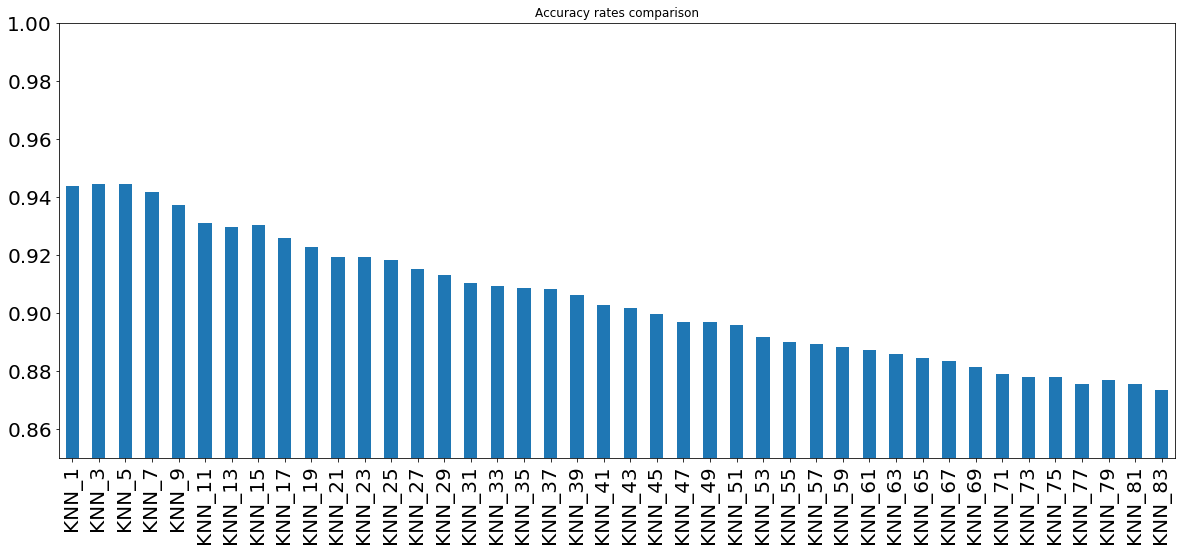

In [145]:
rates_df_all = pd.concat([pd.Series(err_rates_all)],axis = 1)
rates_df_all.index = analyses_names_all
display(rates_df_all)
rates_df_all.transpose()
rates_df_all.plot(kind='bar',figsize=(20,8),rot=90,ylim=(0.85,1),title = "Accuracy rates comparison",legend=False,fontsize=20)


In [131]:
err_rates = []
analyses_names=[]
analyses_results = []
for k in np.arange(1,5,1):
    dataname = 'KNN_'+str(k)
    analyses_names.append(dataname)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(input_data, cleaned_data[0].values)
    prediction = neigh.predict(input_test_data)
    analyses_results.append(prediction)
    err_rates.append(1.0*(cleaned_test_data[0] == prediction).sum()/cleaned_test_data[0].count())


,0
KNN_1,0.943697
KNN_2,0.941206
KNN_3,0.944694
KNN_4,0.943199


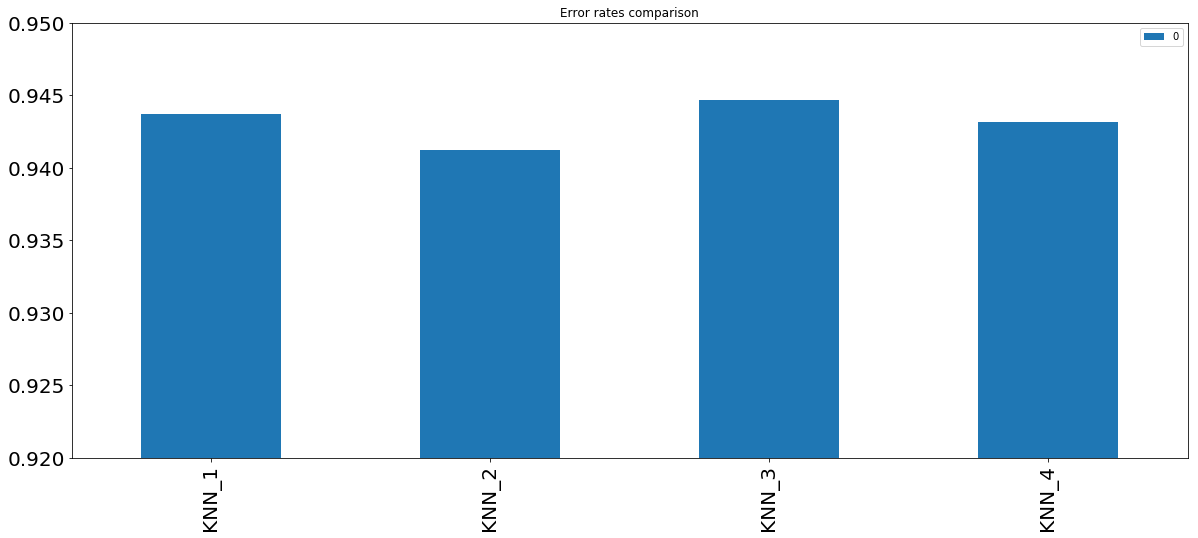

In [137]:
rates5_df = pd.concat([pd.Series(err_rates)],axis = 1)
rates5_df.index = analyses_names
display(rates5_df)
rates5_df.transpose()
rates5_df.plot(kind='bar',figsize=(20,8),rot=90,ylim=(0.92,0.95),title = "Error rates comparison",fontsize=20)
